In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# load dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [19]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.flatten_layer = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)

        self.bottleneck = tf.keras.layers.Dense(16, activation=tf.nn.relu)

        self.dense4 = tf.keras.layers.Dense(32, activation=tf.nn.relu)
        self.dense5 = tf.keras.layers.Dense(64, activation=tf.nn.relu)

        self.dense_final = tf.keras.layers.Dense(784)

    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        # print(x_reshaped.shape)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x_hid = x
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped, x_hid

In [20]:
# define loss function and gradient
def loss(x, x_bar, h, model, Lambda =100):
    reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.mse(x, x_bar)
            )
    reconstruction_loss *= 28 * 28
    W= tf.Variable(model.bottleneck.weights[0])
    dh = h * (1 - h)  # N_batch x N_hidden
    W = tf.transpose(W)
    contractive = Lambda * tf.reduce_sum(tf.linalg.matmul(dh**2,  tf.square(W)), axis=1)
    
    total_loss = reconstruction_loss + contractive
    return total_loss

def grad(model, inputs):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped, hidden = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction, hidden, model)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction


In [15]:
# Train the model
model = AutoEncoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)
num_epochs = 5 # 200
batch_size = 128 # 128

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for x in range(0, len(x_train), batch_size):
        x_inp = x_train[x: x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss: {}".format(tf.reduce_sum(loss_value)))


Epoch:  0
Loss: 3536.8251953125
Epoch:  1
Loss: 3010.154541015625
Epoch:  2
Loss: 2845.3681640625
Epoch:  3
Loss: 2654.1572265625
Epoch:  4
Loss: 2470.782470703125


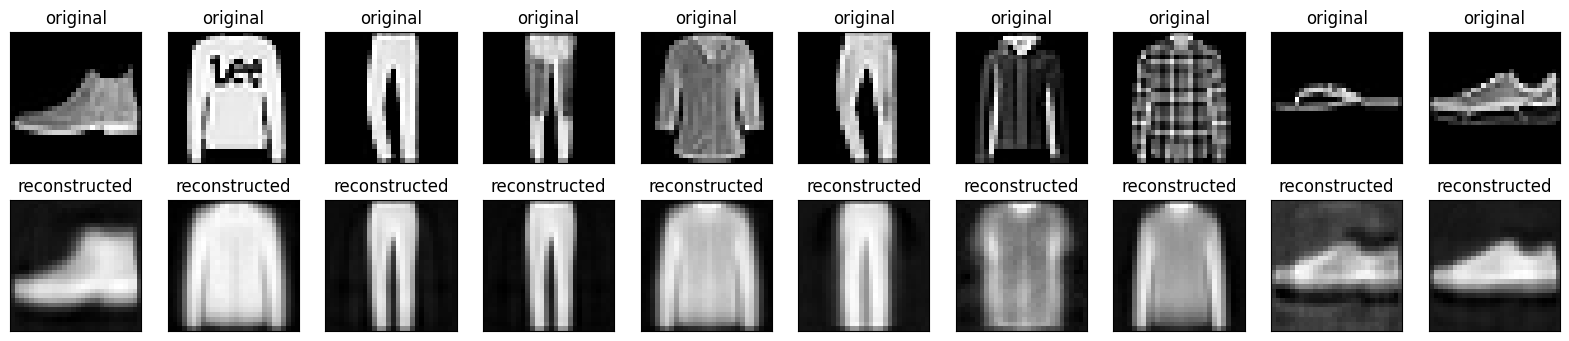

In [17]:
n = 10
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  reconstruction, inputs_reshaped,hidden = model(x_test[i].reshape((1,784)))
  plt.imshow(reconstruction.numpy().reshape((28,28)))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
